# AIN433 - Computer Vision - Assignment 1
# Generalized Hough Transform Based Object Detection
<br />

#### Name: Mohamed Yahya Mansouri

## Introduction

- **The goal of this assignment is to showcase the ability of the Generalized Hough Transform (GHT) algorithm to detect specified objects in a given image. The GHT algorithm is a powerful and intricate algorithm in identifying complex shaped objects, whether they are occuring once or have multiple instances of their presence in a given image. It estimates the location of the object through the geometrical and analytical behavior of its borders (edges).**
- **Two datasets will be used in this assignment. Each is composed of one template and a variety of test images to evaluate the predictive performance of the GHT Model. All images in this dataset are of size 400x400 and png format**
- **The first dataset is a daisy dataset. It is composed of 18 test images and one template.**
- **The second dataset is a fish dataset. It is composed of 19 test images and one template.**

## Necessary Imports

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

import time

## Data Path

In [3]:
files = os.listdir("./dataset_daisy")
print(files)

['scene_00.png', 'scene_01.png', 'scene_02.png', 'scene_03.png', 'scene_04.png', 'scene_05.png', 'scene_06.png', 'scene_07.png', 'scene_08.png', 'scene_09.png', 'scene_10.png', 'scene_11.png', 'scene_12.png', 'scene_13.png', 'scene_14.png', 'scene_15.png', 'scene_17.png', 'template.png']


In [4]:
daisy_dir = "dataset_daisy/"
fish_dir = "dataset_fish/"

scenes_daisy = os.listdir(f"./{daisy_dir}")
scenes_fish = os.listdir(f"./{fish_dir}")

scenes_daisy.remove("template.png")
scenes_fish.remove("template.png")

## Generalized Hough Transform Class-Based Implementation

- **The sobel filter was used as the edge detection technique. This filter is a classic edge detection technique that uses a convolution to estimate horizontal and vertical gradients. It is simple, fast, and computationally effective providing instantanious results. Compared to other operators such as prewitt and roberts, sobel is more efficient as it includes a smoothing effect reducing noise. Compared to other edge detection techniques such as the Canny method, sobel is much simpler in implementation. On the other hand, the Canny method is more robust, more accurate, and handles noise very well. However, it did not provide meaningful differences in results when it was tested against the Sobel effect. Aside from this, the Sobel edge detector was capable of achieving perfect results, as it will be demonstrated in the rest of the assignment.**

In [5]:
class GeneralizedHoughTransform:
    """
    A class-based implementation of Generalized Hough Transform Class.

    The images given to this class are expected to be Gray Images.
    parameters
    ----------

    scales: list of int
        A list of scales. This helps account for different scales
        of arbitrary shapes in the given test image. The test image
        can have the same object of the matched template but with a different
        scale. Testing different scales compensates that.

    rotations: list of int
        A list of different rotation angles in degrees.
        This helps account for different orientations of arbitrary shapes.
        The test image can have the same object of the matched template but in
        a different orientation. Testing different orientations compensates that.

    n_bins: int, default = 24
        Using unique phi angles as indices is computationally expensive
        due to high-cardinality. Binning the angles into discrete values
        is highly effective especially when neighboring pixels have similar orientations.

    magnitude_threshold: int, default = 50
        It is the threshold of acceptable gradient magnitude.
        The threshold is used to filter noise with nonzero
        gradients. The higher the magnitude the sharper 
        the change in color intensity is.
        
    gradient_ksize: int, default = 3
        The size of the kernel of the Sobel filter to detect edges.
        Only odd numbers are expected.
        
    
    Attributes
    ----------
    r_table: dict, default = None
        This is a representation of the shape of the template
        object. It acts as the model of the Generalized Hough Transform
        algorithm. It stores the geometrical properties of edge points
        of the template object relative to a reference point.
        This is useful because the same geometrical properties, taking into
        account different scales and rotations, are expected to manifest
        in other images.

    reference_point: tuple, default = None
        The reference point to be used to analyze the
        edges of the template object.
    """
    def __init__(self, scales, rotations, n_bins = 24, magnitude_threshold = 50, gradient_ksize = 3):
        self.scales = scales
        self.rotations = rotations
        self.n_bins = n_bins
        self.magnitude_threshold = magnitude_threshold
        self.gradient_ksize = gradient_ksize
        self.r_table = None
        self.reference_point = None
    
    def edge_detection(self, image):
        """
        To calculate the edges of an image using the Sobel filter.

        Parameters
        ----------
        image: np.ndarrray
            A matrix representation of the grayscale image.

        Returns
        -------
        A tuple
            - The magnitude of the gradient of each pixel: np.ndarray
            - The orientation of the gradient of each pixel: np.ndarray
        """
        gx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=self.gradient_ksize)
        gy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=self.gradient_ksize)
        gradient_magnitude = cv2.magnitude(gx, gy)
        alpha = (np.rad2deg(np.arctan2(gy, gx)) + 360) % 360 # because arctan2 and rad2deg will give angles in [-180,180]
        return (gradient_magnitude, alpha)

    def get_reference_point(self, template):
        """
        To calculate the reference point. The middle point
        of the shape is used as a reference point -- Based on the
        given datasets.

        Parameters
        ----------
        template: np.ndarray
            A matrix representation of the template image.

        Returns
        -------
        A tuple (x,y) = (j,i)
            - The x-coordinate of the reference point.
            Which is the column(j)
            - The y-coordinate of the reference point.
            Which is the row(i)
        """
        return (template.shape[1] / 2, template.shape[0] / 2)
    
    def fit(self, template):
        """
            Fit the GHT model to the template image.
            This created the r_table of the template image.

            As mentioned before, binning is used instead of unique
            phi angle values as indices.

            Parameters
            ----------
            template: np.ndarray
                A matrix representation of the template image.
            
        """
        self.r_table = defaultdict(list)
        self.reference_point = self.get_reference_point(template)
        magnitude, gradient_orientation = self.edge_detection(template)
        
        ## Visualizing The Edge Map for the Template
        fig, axes = plt.subplots()
        axes.add_artist(plt.Circle((self.reference_point[0],self.reference_point[1]),3, color="r"))
        plt.imshow(magnitude, cmap="gray", vmin=0, vmax=255)
        axes.legend(["Reference Point"])
        plt.title("Edge Map for the Template Image")
        plt.show()
        
        bin_width = 360 / self.n_bins
        rows, cols = template.shape
        mask_magnitude = magnitude > self.magnitude_threshold
        for i in range(rows):
            for j in range(cols):
                if mask_magnitude[i,j]:
                    phi = gradient_orientation[i,j]
                    dy = self.reference_point[1] - i
                    dx = self.reference_point[0] - j
                    r = np.sqrt(dx ** 2 + dy ** 2)
                    direction = (np.rad2deg(np.arctan2(dy,dx)) + 360) % 360 # No need to change this to degrees because will not be used for indexing
                    phi_index = np.floor(phi / bin_width) % self.n_bins
                    self.r_table[phi_index].append((r, direction))

    def predict(self, test_img):
        """
        Perform object detection on a test image.
        This computes the accumulator array which stores the potential
        reference centers of each pixel. This method computes edge gradients
        of the test image and compares them to those of the template image using
        the r_table. Then, the accumulator uses a voting mechanism to give out
        the best reference point, representing the detected object, while taking
        into account different scales and rotations.

        Parameters
        ----------
        test_img: np.ndarray
            A matrix representation of the test image.

        Returns
        -------
        A 4D matrix of potential reference points.
            Its coordinate system is: (x_coordinate, y_coordinate, scale, rotation)
            Each cell contains a vote count of likely the values of the coordinate
            system represents the original reference point of the template.
        """
        bin_width = 360 / self.n_bins
        test_img_magnitude, test_img_gradient = self.edge_detection(test_img)
        ys,xs = np.indices(test_img.shape)
        
        ys = ys.flatten()
        xs = xs.flatten()
        test_img_magnitude = test_img_magnitude.flatten()
        test_img_gradient = test_img_gradient.flatten()
        
        magnitude_threshold = test_img_magnitude > self.magnitude_threshold
        
        accumulator = np.zeros((test_img.shape[0], test_img.shape[1], len(self.scales), len(self.rotations)))
        
        for scale_index, scale in enumerate(self.scales):
            for rotation_index, rotation in enumerate(self.rotations):
                for idx in range(len(xs)):
                    if magnitude_threshold[idx]:
                        phi = (test_img_gradient[idx] - rotation) % 360
                        phi_index = int(np.floor((phi / bin_width)) % self.n_bins)
                        phi_displacements = np.array(self.r_table[phi_index])
                        if len(phi_displacements) == 0:
                            continue
                        angles = phi_displacements[:,1]
                        radii = phi_displacements[:,0]
                        x_c = xs[idx] + radii * scale * np.cos(np.radians(angles + rotation)) # It was chosen + not - because r was calculated from edge to center
                        y_c = ys[idx] + radii * scale * np.sin(np.radians(angles + rotation))
        
                        filter_ = (x_c < accumulator.shape[1]) & (x_c >= 0) & (y_c < accumulator.shape[0]) & (y_c >= 0)
                        x_c = np.floor(x_c[filter_]).astype(int)
                        y_c = np.floor(y_c[filter_]).astype(int)
                        
                        accumulator[y_c, x_c, scale_index, rotation_index] += 1
        return accumulator
        
    def detect(self, accumulator, radius, n_best, count_threshold_percentage = 0.5, count_threshold_nbr = 100):
        """
        Using the accumulator array, this method returns the n_best
        reference points. Since very close neighboring pixels can have
        very high voting points, every best reference point is taken
        and its neighbors within a specified radius will be nullified.

        Parameters
        ----------
        accumulator: np.ndarray
            A 4D matrix of potential reference points.
            Its coordinate system is: (x_coordinate, y_coordinate, scale, rotation)
            Each cell contains a vote count of likely the values of the coordinate
            system represents the original reference point of the template.

        radius: int
            The radius, or gap, between the ith chosen reference point
            and its neighboring elements within a distance of radius.

        n_best: int
            The nth elements with the highest vote counts.

        count_threshold_percentage: float
            If a vote count is less than the maximum vote
            of a certain percentage, then it will be rejected
            and the look for reference points will stop.
            The value is < 1.

        count_threshold_nbr: int
            If a vote count is less than this threshold
            then the scene is considered empty of detection points.

            Afte analysis, it was discovered that the empty scenes have
            detection points but sparse and each with very low vote counts.
        
        Returns
        -------
        best_parameters: list
            A list of values of the n_best coordinate values with the
            highest vote counts.
        """
        best_parameters = []
        accumulator_used = accumulator.copy()
        maximum = 0
        for i in range (n_best):
            flat_indices = np.argsort(accumulator_used, axis=None)
            target_flat_index = flat_indices[-1]
            y,x,s,r = np.unravel_index(target_flat_index, accumulator_used.shape)
            if maximum < accumulator_used[y,x,s,r]:
                maximum = accumulator_used[y,x, s,r]
            if (maximum < count_threshold_nbr) or (accumulator_used[y, x, s, r] < maximum * count_threshold_percentage):
                break
            best_parameters.append((x, y, s, r))
            y_min = np.max([0, y - radius])
            y_max = np.min([accumulator_used.shape[0], y + radius + 1])
            x_min = np.max([0, x - radius])
            x_max = np.min([accumulator_used.shape[1], x + radius + 1])
            accumulator_used[y_min:y_max, x_min:x_max, :, :] = 0
        return best_parameters

## Application

### Necessary Functions

In [6]:
def detect_images(dir_name, images, radius=20, n_best=5, count_threshold_percentage = 0.5, count_threshold_nbr = 100):
    """
    Takes a list of images to test the performance of the GHT model.
    It also prints the time taken to detect the template in every
    test image of the images list.

    This method is customized only for the names of the image files
    given in this assingment. It is expected to be in the format of
    "scene_xy.png"
    
    Paramaters
    ----------
    dir_name: str
        The directory name of the dataset

    images: list of int
        The names of the image files. However, only the
        indices are written, not the full name.
        Example:
        - For an image of a name "scene_00.png" only "00" is to be
        found in the list of the images parameter.

    Returns
    -------
    a tuple
    - paramteres: list of arrays
        For each test image, a list/array of the best detected object parameters
        (x, y, scale, rotation) corresponding to the highest vote counts.
    - accumulators: list of np.ndarray
        For each test image, the accumulator array computed.
    """
    parameters = []
    accumulators = []
    for scene in images:
        starting = time.time()
        test_img = read_img(dir_name, scene)
        accumulator = ght.predict(test_img)
        accumulators.append(accumulator)
        best_parameters = ght.detect(accumulator, radius = radius, n_best = n_best, count_threshold_percentage = count_threshold_percentage, count_threshold_nbr = count_threshold_nbr)
        parameters.append(best_parameters)
        print(f"It took {time.time() - starting:.3f} seconds.")
    return (parameters, accumulators)

def visualize_output(dir_name, images, parameters, accumulators, colormap):
    """
    It visualizes the detected template centers on the scene image by drawing
    a red circle in the center points. It also indicates the best vote count
    object.
    It prints the detected center (x,y) along with the optimal scale
    and rotation.

    Parameters
    ----------
    dir_name: str
        The directory name of the dataset

    images: list of int
        The names of the image files. However, only the
        indices are written, not the full name.
        Example:
        - For an image of a name "scene_00.png" only "00" is to be
        found in the list of the images parameter.

    parameters: list of arrays
        For each test image, a list/array of the best detected object parameters
        (x, y, scale, rotation) corresponding to the highest vote counts.

    accumulators: list of np.ndarray
        For each test image, the accumulator array computed.
    """
    for i, parameter in enumerate(parameters):
        print(f"---- Scene Image Number {i + 1} with File Name {images[i]} ----")
        test_img = read_img(dir_name, images[i])
        fig, axes = plt.subplots(1, 2, figsize=(12,12))
        if len(parameter) != 0:
            axes[0].scatter(parameter[0][0], parameter[0][1], s=90, c='lightgreen', marker='x', zorder=3)
        axes[0].set_aspect(1)
        for j, (x,y,s,r) in enumerate(parameter):
            print(f"""
                     --- Detection Number {j + 1} ---
                            Votes: {int(accumulators[i][y,x,s,r])}
                            Detected Center ({x},{y})
                            Scale: {scales[s]}
                            Rotation: {rotations[r]} deg"""
                 )
            axes[0].add_artist(plt.Circle((x,y),7, color="r"))
        # axes.legend(["Best","Top 5"])
        axes[0].imshow(test_img, cmap='gray', vmin=0, vmax=255)
        axes[0].set_title("Detections")
        accumulator_2d = np.max(accumulators[i], axis=(2,3))
        img = axes[1].imshow(accumulator_2d, cmap=colormap)
        plt.colorbar(img, ax=axes[1], fraction=0.046)
        axes[1].set_title("Accumulator")
        plt.show()

def read_img(dir_name, img_name):
    """
    Reads an image and return it as a gray image.
    
    Parameters
    ----------
    dir_name: str
        Directory name of the image

    img_name: str
        File name of the image

    Returns
    -------
    scene: np.ndarray
        Matrix representation of the gray image.
    """
    scene = cv2.imread(dir_name + img_name)
    scene = cv2.cvtColor(scene, cv2.COLOR_BGR2GRAY)
    return scene

def plot_img(img):
    plt.imshow(img, cmap="gray", vmin=0, vmax=255)
    plt.show()

### Model Initialization

In [7]:
# Setting Up the model with general parameters (i.e scales rotations)
scales = [1,1.5, 2,3]
rotations = np.arange(0,360, 15)

ght = GeneralizedHoughTransform(scales, rotations)

### Daisy Dataset

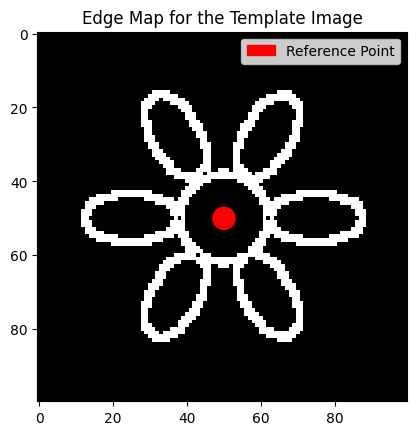

In [8]:
template_daisy = read_img(daisy_dir, "template.png")
ght.fit(template_daisy)

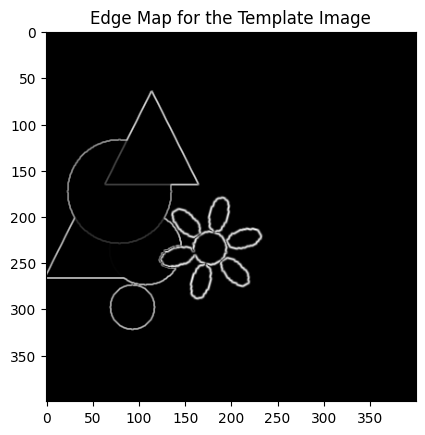

In [9]:
# Visualizating Heatmap for 1 scene image from daisy
fig, axes = plt.subplots()
scene_img = read_img(daisy_dir, np.random.choice(scenes_daisy))
scene_magnitude,_  = ght.edge_detection(scene_img)
plt.imshow(scene_magnitude, cmap="gray")
plt.title("Edge Map for the Template Image")
plt.show()

In [10]:
# Predicting
parameters_daisy, accumulators_daisy = detect_images(daisy_dir, scenes_daisy, count_threshold_percentage=0.5, count_threshold_nbr=100)

It took 52.549 seconds.
It took 54.214 seconds.
It took 32.192 seconds.
It took 21.338 seconds.
It took 43.703 seconds.
It took 33.554 seconds.
It took 16.108 seconds.
It took 60.228 seconds.
It took 26.289 seconds.
It took 27.806 seconds.
It took 43.688 seconds.
It took 69.214 seconds.
It took 29.349 seconds.
It took 23.161 seconds.
It took 45.095 seconds.
It took 44.088 seconds.
It took 35.715 seconds.


---- Scene Image Number 1 with File Name scene_00.png ----

                     --- Detection Number 1 ---
                            Votes: 366
                            Detected Center (210,272)
                            Scale: 2
                            Rotation: 300 deg

                     --- Detection Number 2 ---
                            Votes: 298
                            Detected Center (266,223)
                            Scale: 1
                            Rotation: 285 deg


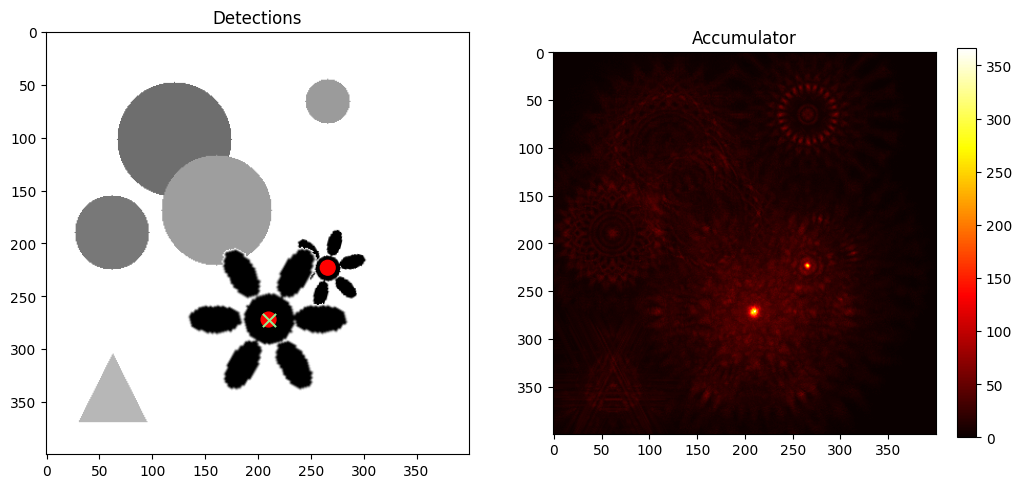

---- Scene Image Number 2 with File Name scene_01.png ----

                     --- Detection Number 1 ---
                            Votes: 475
                            Detected Center (166,198)
                            Scale: 1
                            Rotation: 345 deg

                     --- Detection Number 2 ---
                            Votes: 410
                            Detected Center (284,198)
                            Scale: 2
                            Rotation: 60 deg

                     --- Detection Number 3 ---
                            Votes: 391
                            Detected Center (100,243)
                            Scale: 1
                            Rotation: 255 deg


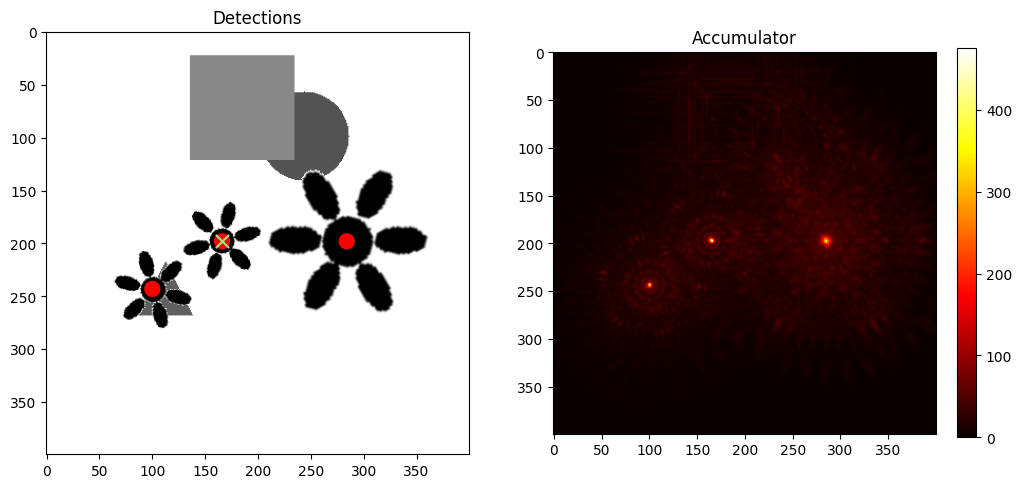

---- Scene Image Number 3 with File Name scene_02.png ----

                     --- Detection Number 1 ---
                            Votes: 392
                            Detected Center (308,143)
                            Scale: 1.5
                            Rotation: 315 deg


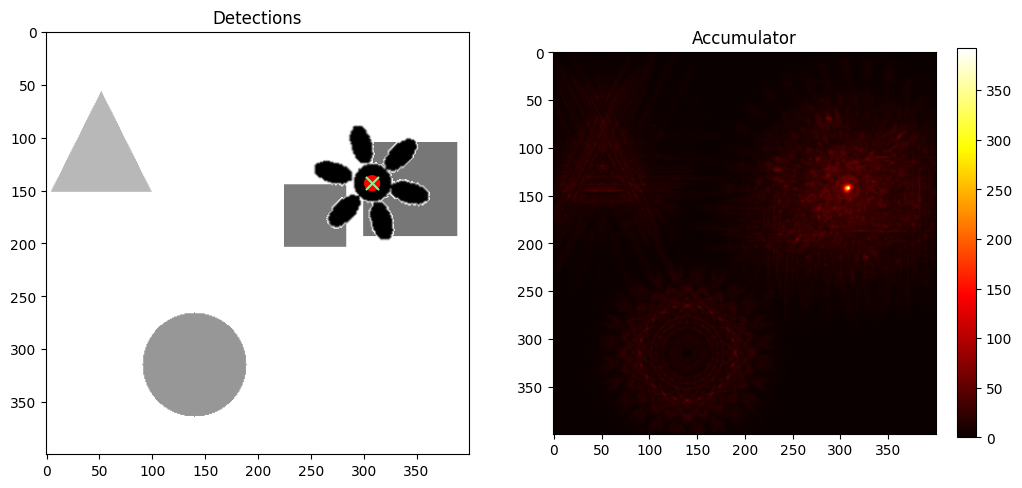

---- Scene Image Number 4 with File Name scene_03.png ----

                     --- Detection Number 1 ---
                            Votes: 475
                            Detected Center (106,128)
                            Scale: 1
                            Rotation: 345 deg


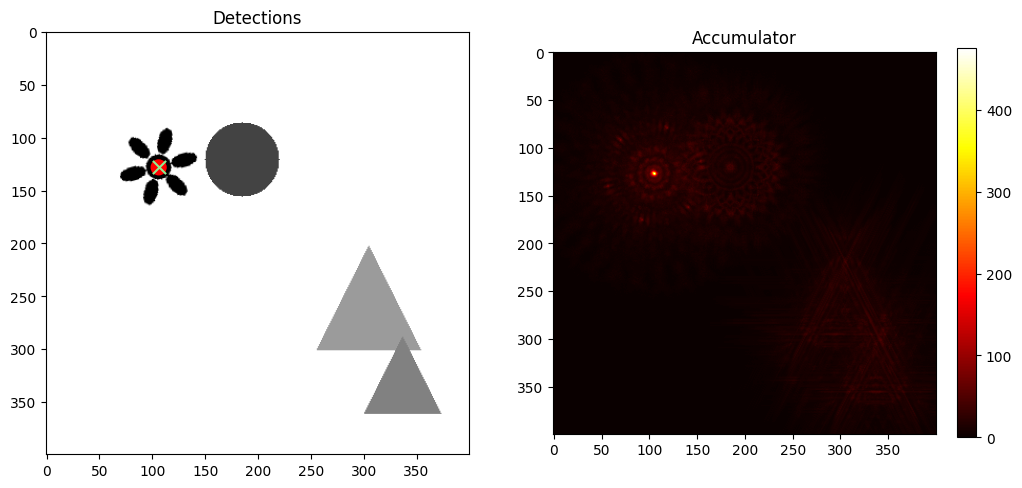

---- Scene Image Number 5 with File Name scene_04.png ----

                     --- Detection Number 1 ---
                            Votes: 445
                            Detected Center (266,156)
                            Scale: 1.5
                            Rotation: 300 deg

                     --- Detection Number 2 ---
                            Votes: 401
                            Detected Center (202,308)
                            Scale: 1
                            Rotation: 60 deg


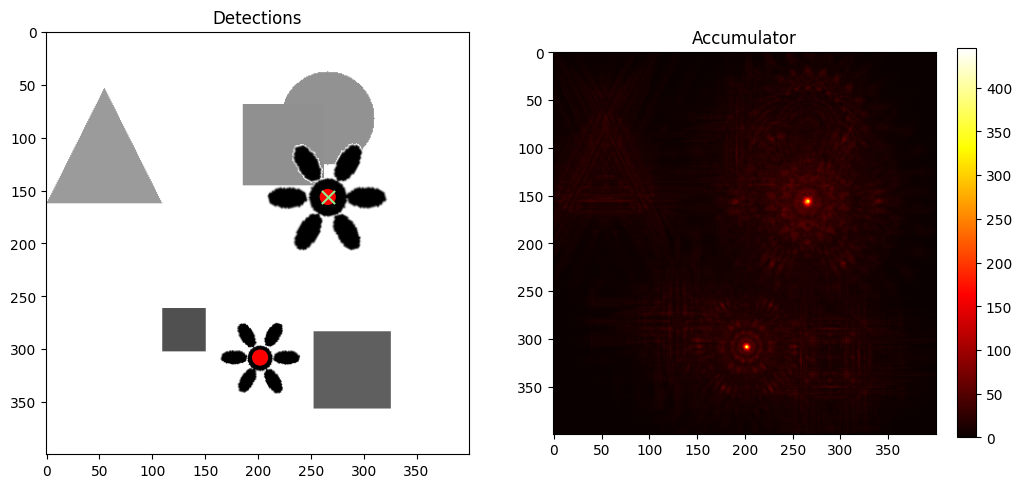

---- Scene Image Number 6 with File Name scene_05.png ----

                     --- Detection Number 1 ---
                            Votes: 460
                            Detected Center (176,234)
                            Scale: 1.5
                            Rotation: 105 deg


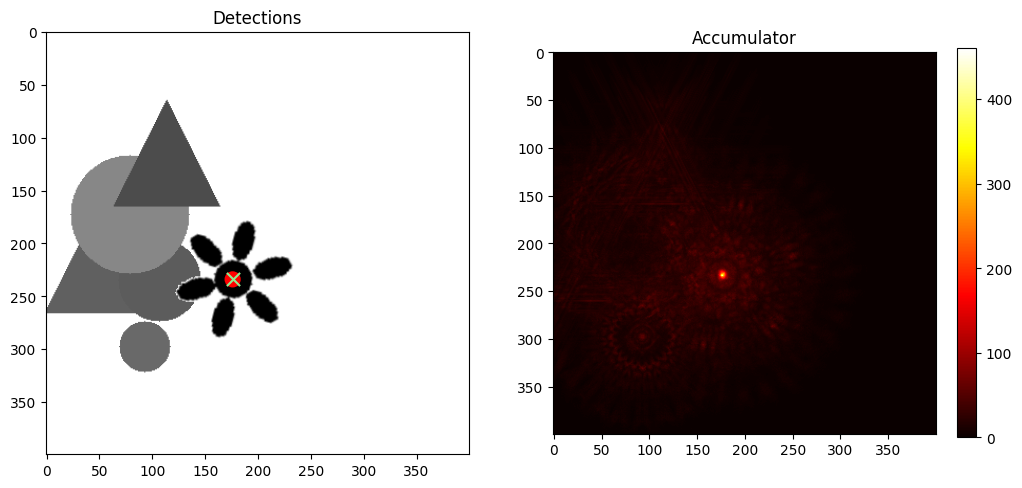

---- Scene Image Number 7 with File Name scene_06.png ----


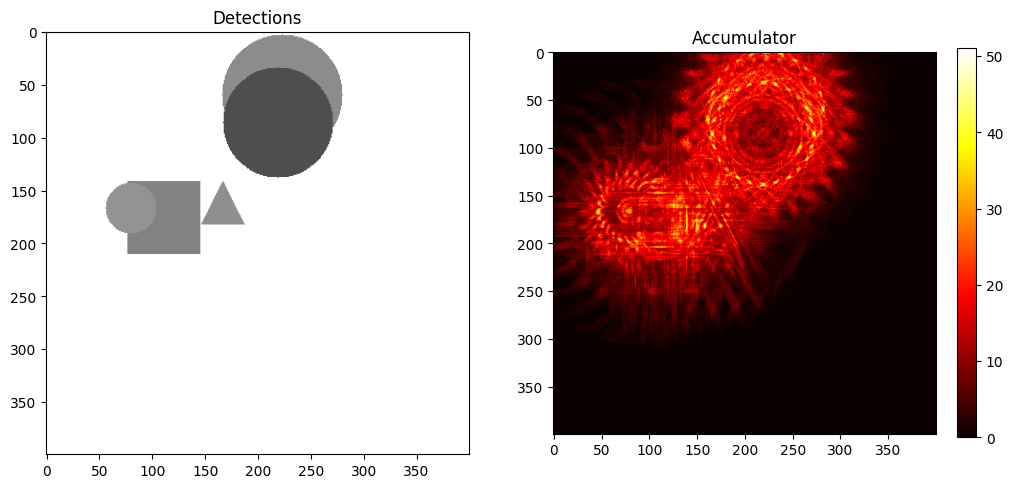

---- Scene Image Number 8 with File Name scene_07.png ----

                     --- Detection Number 1 ---
                            Votes: 453
                            Detected Center (303,146)
                            Scale: 1.5
                            Rotation: 105 deg

                     --- Detection Number 2 ---
                            Votes: 451
                            Detected Center (227,198)
                            Scale: 2
                            Rotation: 315 deg


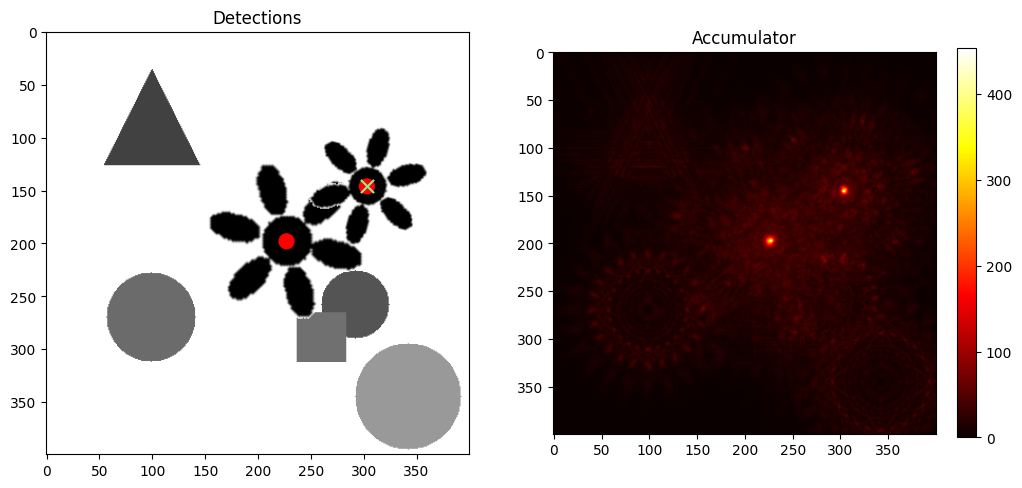

---- Scene Image Number 9 with File Name scene_08.png ----

                     --- Detection Number 1 ---
                            Votes: 527
                            Detected Center (104,158)
                            Scale: 1.5
                            Rotation: 180 deg


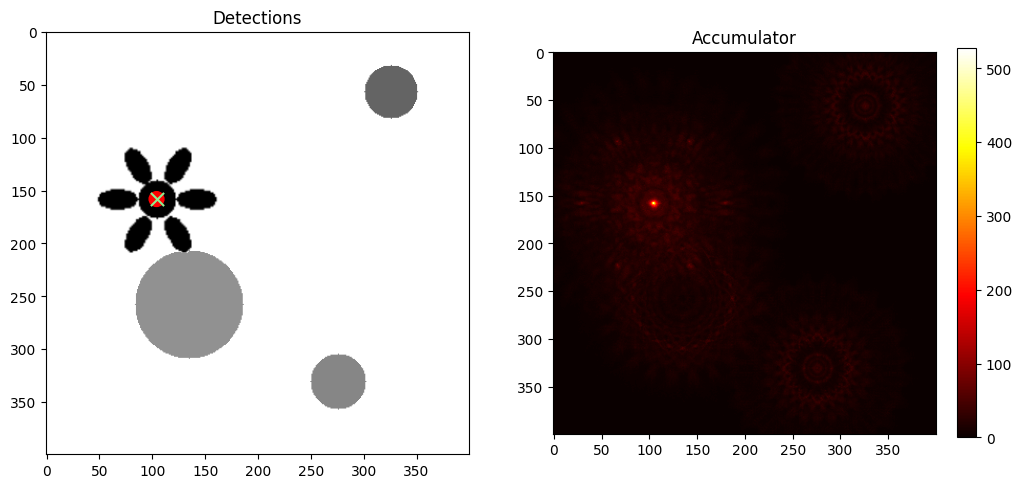

---- Scene Image Number 10 with File Name scene_09.png ----

                     --- Detection Number 1 ---
                            Votes: 364
                            Detected Center (83,170)
                            Scale: 1
                            Rotation: 75 deg

                     --- Detection Number 2 ---
                            Votes: 246
                            Detected Center (90,145)
                            Scale: 1
                            Rotation: 120 deg


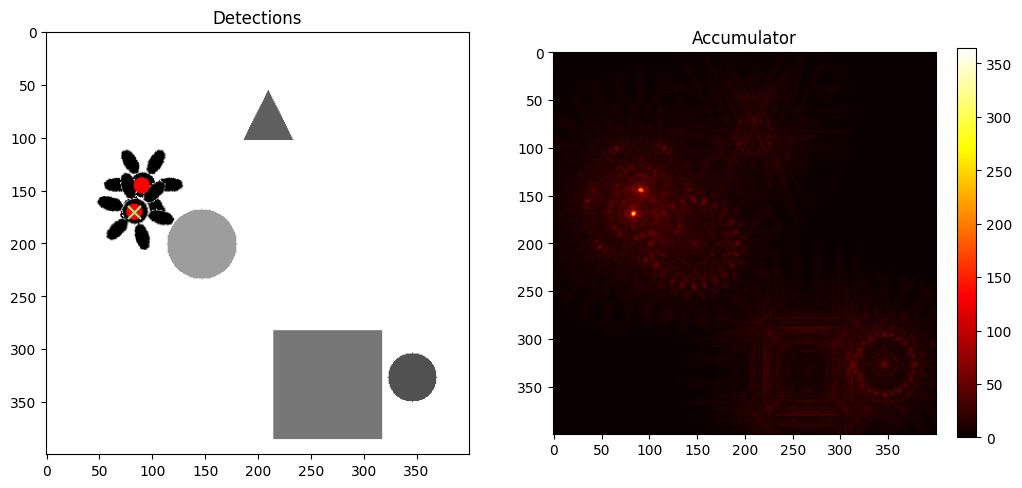

---- Scene Image Number 11 with File Name scene_10.png ----

                     --- Detection Number 1 ---
                            Votes: 586
                            Detected Center (166,252)
                            Scale: 2
                            Rotation: 180 deg


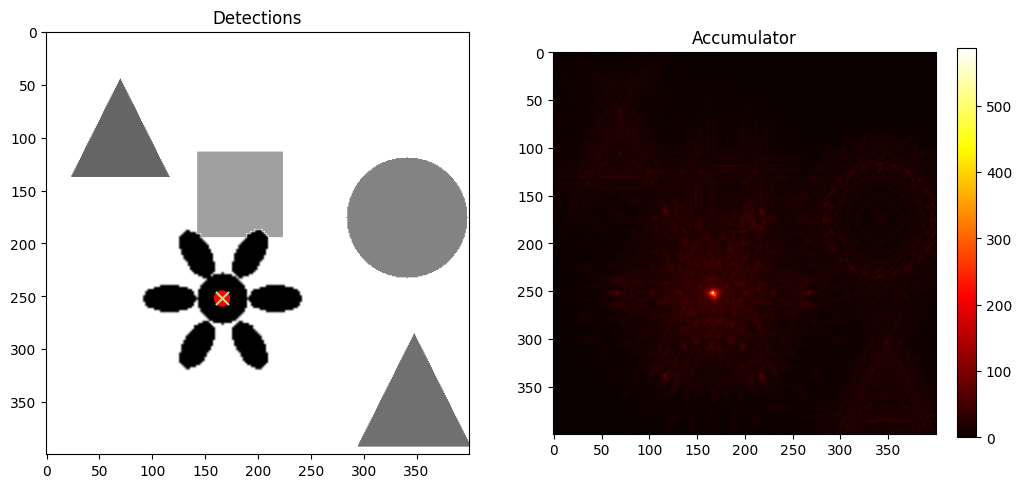

---- Scene Image Number 12 with File Name scene_11.png ----

                     --- Detection Number 1 ---
                            Votes: 457
                            Detected Center (293,86)
                            Scale: 1
                            Rotation: 255 deg

                     --- Detection Number 2 ---
                            Votes: 444
                            Detected Center (150,86)
                            Scale: 1.5
                            Rotation: 270 deg

                     --- Detection Number 3 ---
                            Votes: 351
                            Detected Center (220,257)
                            Scale: 2
                            Rotation: 330 deg


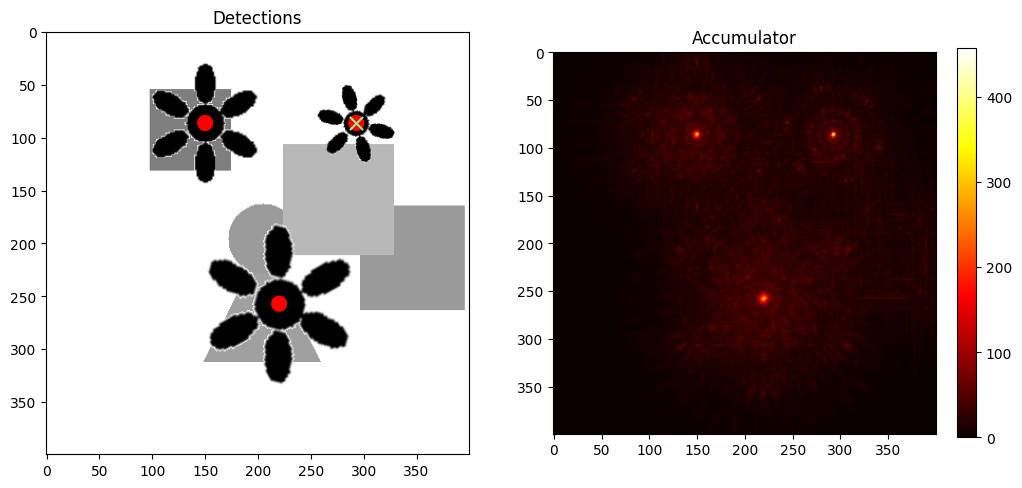

---- Scene Image Number 13 with File Name scene_12.png ----

                     --- Detection Number 1 ---
                            Votes: 365
                            Detected Center (266,191)
                            Scale: 1
                            Rotation: 60 deg


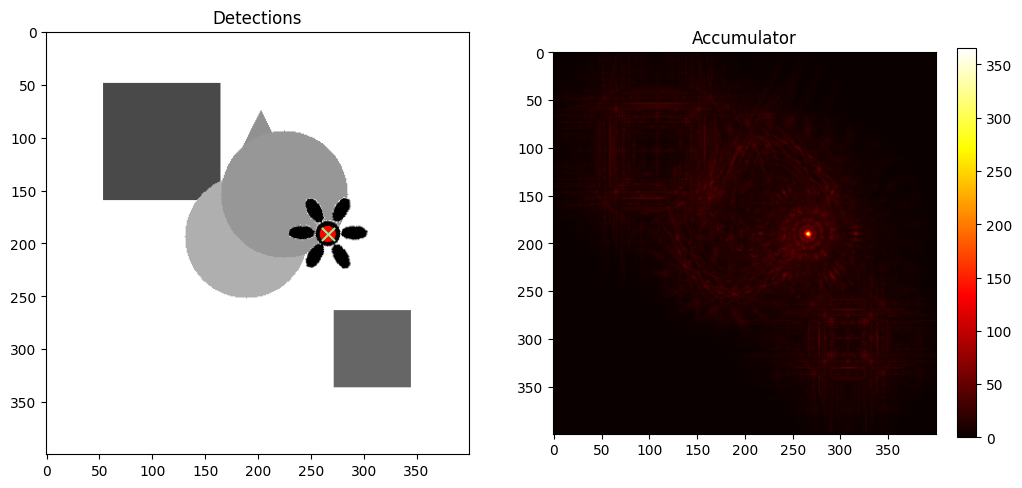

---- Scene Image Number 14 with File Name scene_13.png ----

                     --- Detection Number 1 ---
                            Votes: 365
                            Detected Center (126,329)
                            Scale: 1
                            Rotation: 30 deg


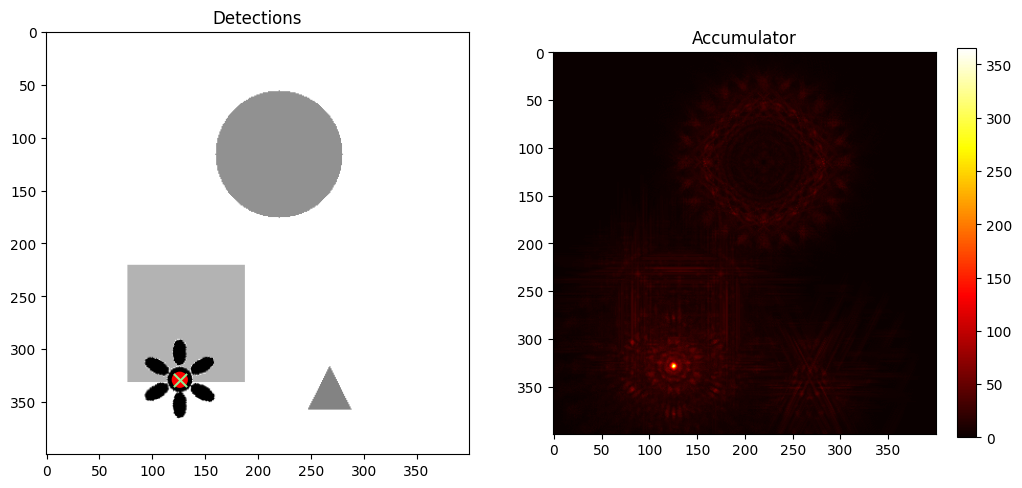

---- Scene Image Number 15 with File Name scene_14.png ----

                     --- Detection Number 1 ---
                            Votes: 473
                            Detected Center (286,86)
                            Scale: 1.5
                            Rotation: 285 deg

                     --- Detection Number 2 ---
                            Votes: 457
                            Detected Center (127,256)
                            Scale: 1.5
                            Rotation: 45 deg


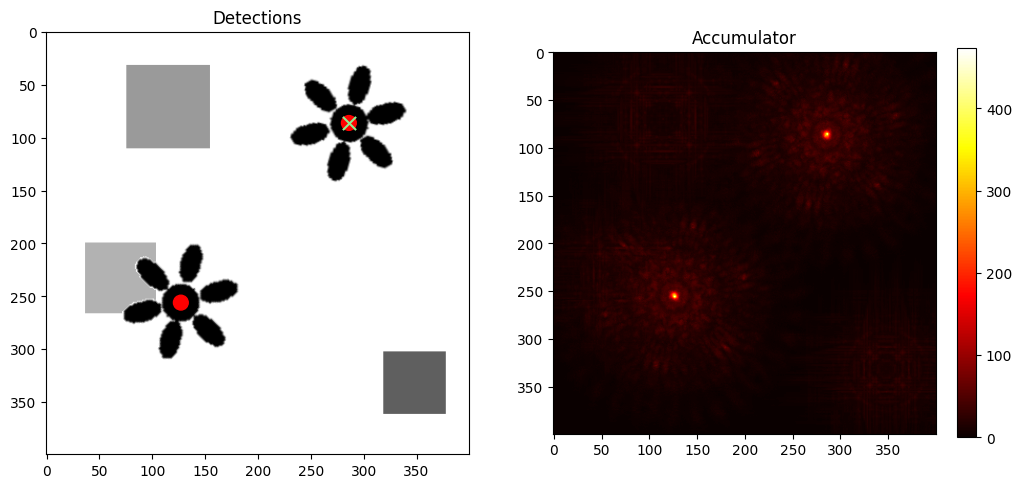

---- Scene Image Number 16 with File Name scene_15.png ----

                     --- Detection Number 1 ---
                            Votes: 438
                            Detected Center (216,213)
                            Scale: 2
                            Rotation: 225 deg

                     --- Detection Number 2 ---
                            Votes: 403
                            Detected Center (148,253)
                            Scale: 1
                            Rotation: 45 deg


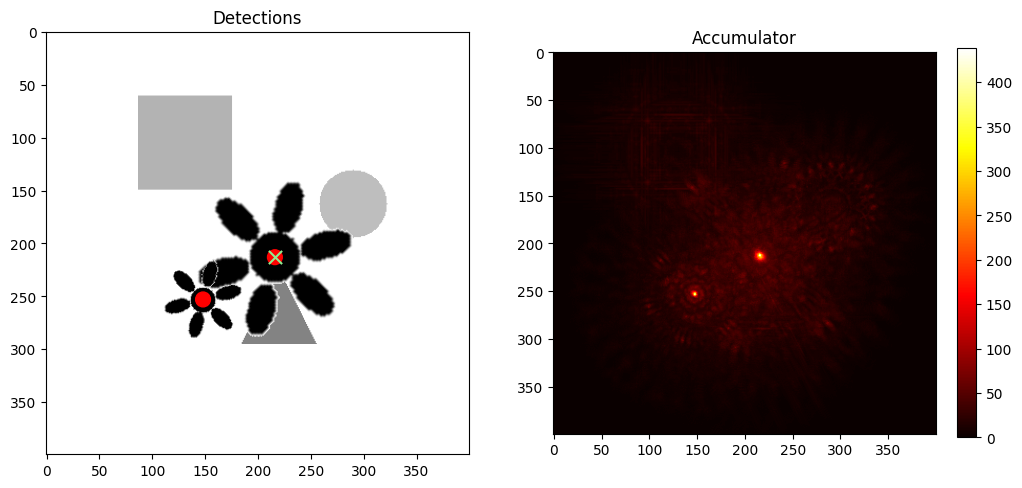

---- Scene Image Number 17 with File Name scene_17.png ----

                     --- Detection Number 1 ---
                            Votes: 503
                            Detected Center (268,163)
                            Scale: 1.5
                            Rotation: 165 deg


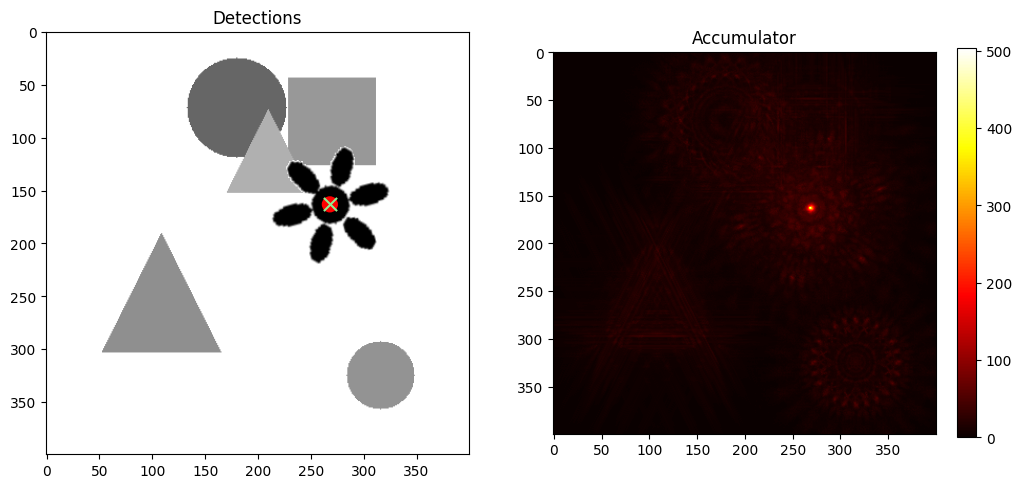

In [11]:
visualize_output(dir_name = daisy_dir, images = scenes_daisy, parameters = parameters_daisy, accumulators = accumulators_daisy, colormap = "hot")

- **All of the daisy objects were perfectly, and beautifully I might add, detected in the chosen scenes.**
- **Analayzing the color bars of the the accumulator heatmaps, the vote count range in empty scenes (scene_06) is notabely less to that in images with the template objects present in them. The minimum vote count for the detected objects was 246 (scene_09). As a result, this characteristic was used to discard the noisy points detected especially for empty scenes. One factor that led to this infalted vote count was the use of binning in the r_table instead of using unique phi angles as indices. Binning was helpful to account for the multiple detection points for the same center point.**
- **The average time it took to train the data was 39 seconds.**
- **Since the accumulator array was 4D, the maximum value out of the (scale, rotation) combination was picked to create a 2D array.**

### Fish Dataset

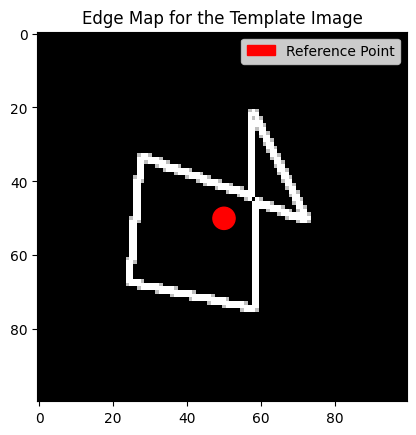

In [12]:
# Importing Files
template_fish = read_img(fish_dir, "template.png")
ght.fit(template_fish)

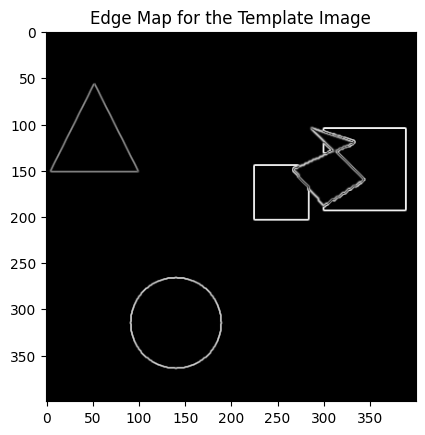

In [13]:
# Visualizating Heatmap for 1 scene image from daisy
scene_img_fish = read_img(fish_dir, np.random.choice(scenes_fish))
scene_magnitude_fish,_  = ght.edge_detection(scene_img_fish)

fig, axes = plt.subplots()
plt.imshow(scene_magnitude_fish, cmap="gray")
plt.title("Edge Map for the Template Image")
plt.show()

In [14]:
# Predicting
parameters_fish, accumulators_fish = detect_images(fish_dir, scenes_fish, count_threshold_percentage=0.55, count_threshold_nbr=100)

It took 25.577 seconds.
It took 22.224 seconds.
It took 28.692 seconds.
It took 12.980 seconds.
It took 26.834 seconds.
It took 22.087 seconds.
It took 13.992 seconds.
It took 34.426 seconds.
It took 16.647 seconds.
It took 20.515 seconds.
It took 25.684 seconds.
It took 22.896 seconds.
It took 21.645 seconds.
It took 17.462 seconds.
It took 22.420 seconds.
It took 22.957 seconds.
It took 15.595 seconds.
It took 28.030 seconds.
It took 35.968 seconds.


---- Scene Image Number 1 with File Name scene_00.png ----

                     --- Detection Number 1 ---
                            Votes: 172
                            Detected Center (211,271)
                            Scale: 2
                            Rotation: 300 deg

                     --- Detection Number 2 ---
                            Votes: 166
                            Detected Center (266,223)
                            Scale: 1
                            Rotation: 285 deg


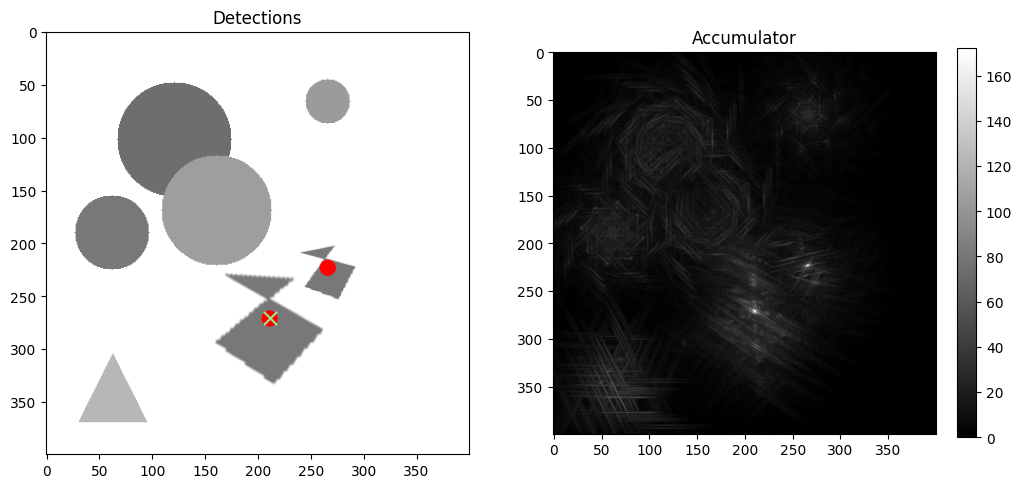

---- Scene Image Number 2 with File Name scene_01.png ----

                     --- Detection Number 1 ---
                            Votes: 253
                            Detected Center (165,197)
                            Scale: 1
                            Rotation: 345 deg

                     --- Detection Number 2 ---
                            Votes: 192
                            Detected Center (285,198)
                            Scale: 2
                            Rotation: 60 deg

                     --- Detection Number 3 ---
                            Votes: 182
                            Detected Center (100,244)
                            Scale: 1
                            Rotation: 255 deg


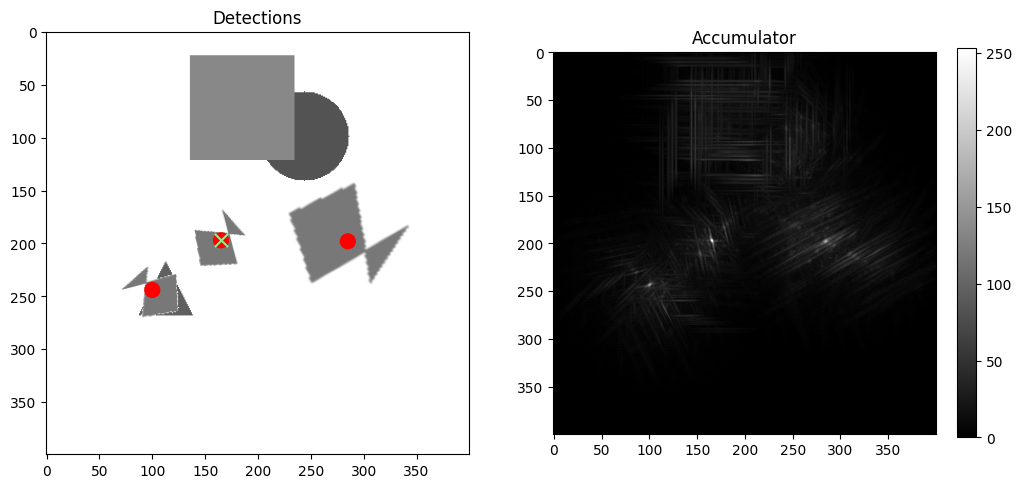

---- Scene Image Number 3 with File Name scene_02.png ----

                     --- Detection Number 1 ---
                            Votes: 214
                            Detected Center (241,103)
                            Scale: 1.5
                            Rotation: 45 deg

                     --- Detection Number 2 ---
                            Votes: 176
                            Detected Center (208,260)
                            Scale: 2
                            Rotation: 330 deg

                     --- Detection Number 3 ---
                            Votes: 130
                            Detected Center (236,280)
                            Scale: 1.5
                            Rotation: 345 deg


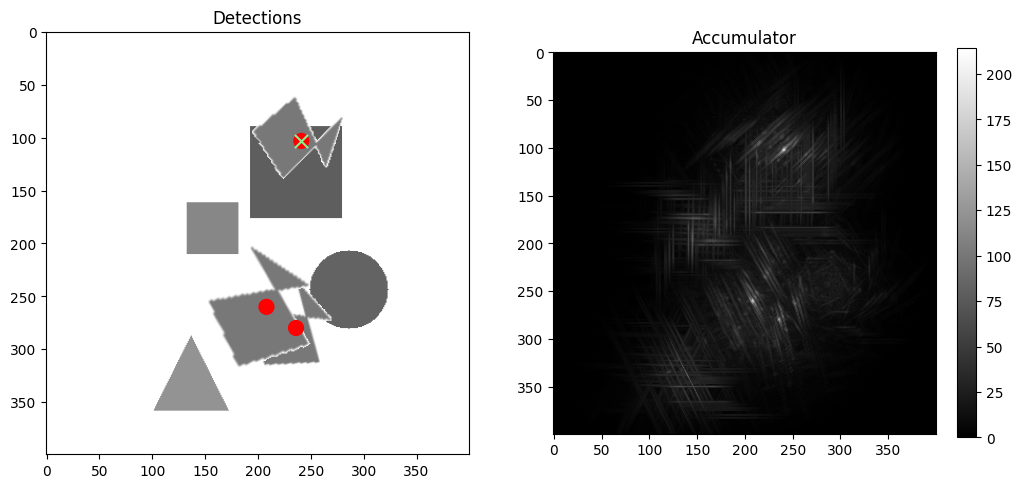

---- Scene Image Number 4 with File Name scene_03.png ----

                     --- Detection Number 1 ---
                            Votes: 253
                            Detected Center (105,127)
                            Scale: 1
                            Rotation: 345 deg


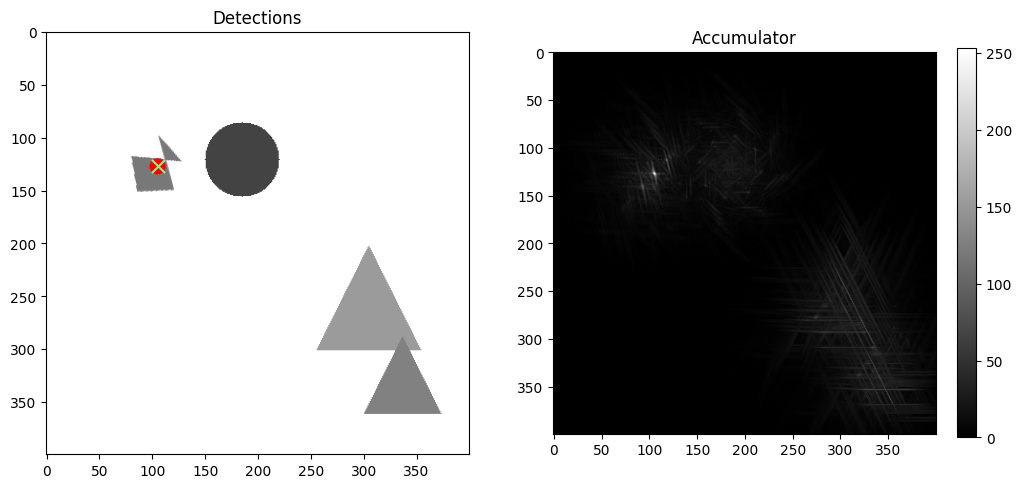

---- Scene Image Number 5 with File Name scene_04.png ----

                     --- Detection Number 1 ---
                            Votes: 204
                            Detected Center (202,308)
                            Scale: 1
                            Rotation: 60 deg

                     --- Detection Number 2 ---
                            Votes: 181
                            Detected Center (266,156)
                            Scale: 1.5
                            Rotation: 300 deg


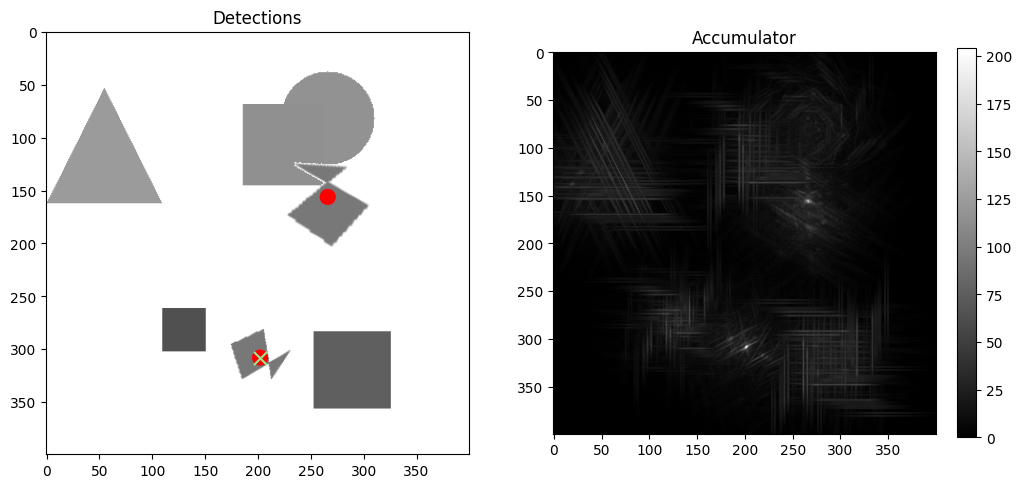

---- Scene Image Number 6 with File Name scene_05.png ----

                     --- Detection Number 1 ---
                            Votes: 198
                            Detected Center (176,234)
                            Scale: 1.5
                            Rotation: 105 deg


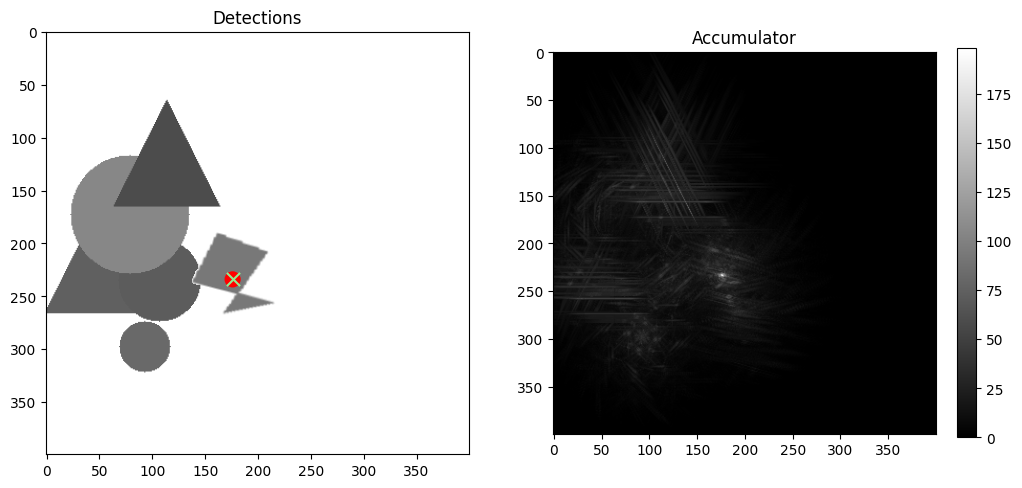

---- Scene Image Number 7 with File Name scene_06.png ----


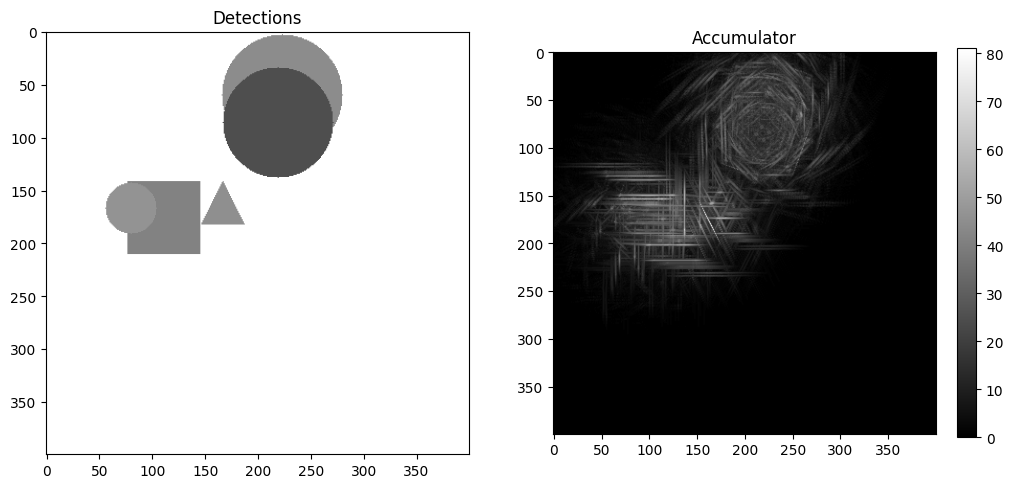

---- Scene Image Number 8 with File Name scene_07.png ----

                     --- Detection Number 1 ---
                            Votes: 264
                            Detected Center (227,197)
                            Scale: 2
                            Rotation: 315 deg

                     --- Detection Number 2 ---
                            Votes: 205
                            Detected Center (303,146)
                            Scale: 1.5
                            Rotation: 105 deg


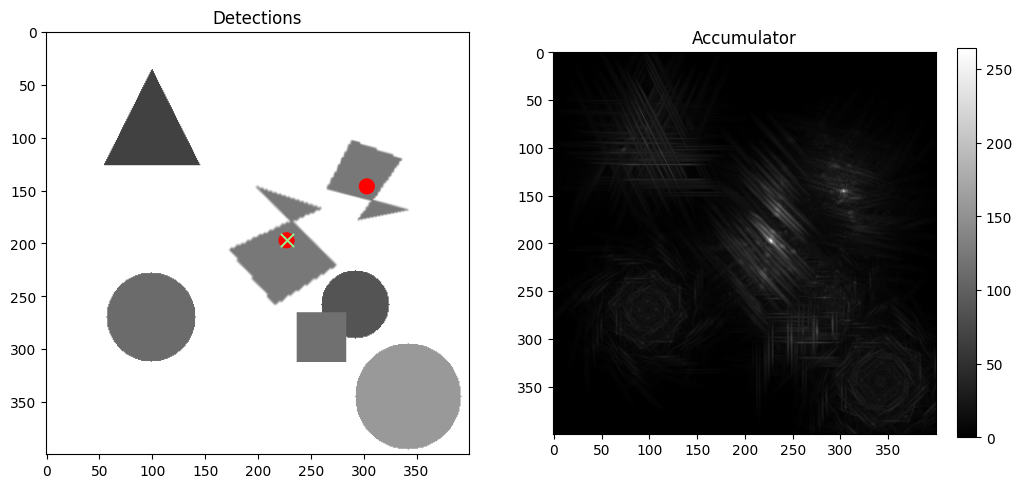

---- Scene Image Number 9 with File Name scene_08.png ----

                     --- Detection Number 1 ---
                            Votes: 261
                            Detected Center (104,159)
                            Scale: 1.5
                            Rotation: 180 deg


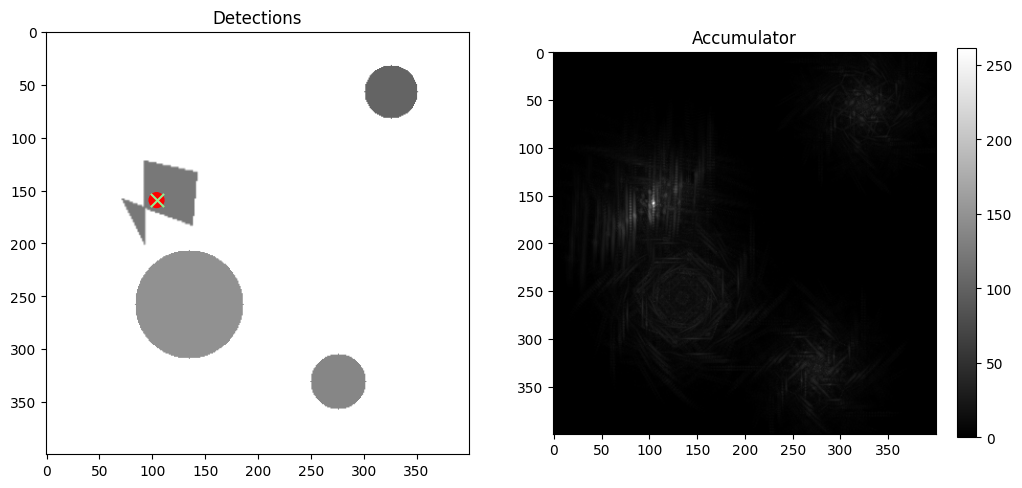

---- Scene Image Number 10 with File Name scene_09.png ----

                     --- Detection Number 1 ---
                            Votes: 215
                            Detected Center (83,170)
                            Scale: 1
                            Rotation: 75 deg

                     --- Detection Number 2 ---
                            Votes: 132
                            Detected Center (91,145)
                            Scale: 1
                            Rotation: 120 deg


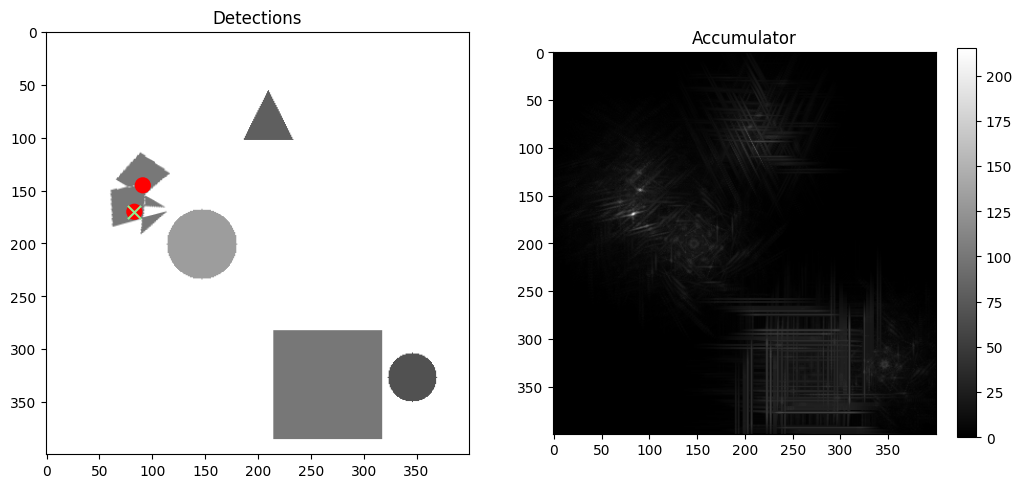

---- Scene Image Number 11 with File Name scene_10.png ----

                     --- Detection Number 1 ---
                            Votes: 300
                            Detected Center (166,253)
                            Scale: 2
                            Rotation: 180 deg


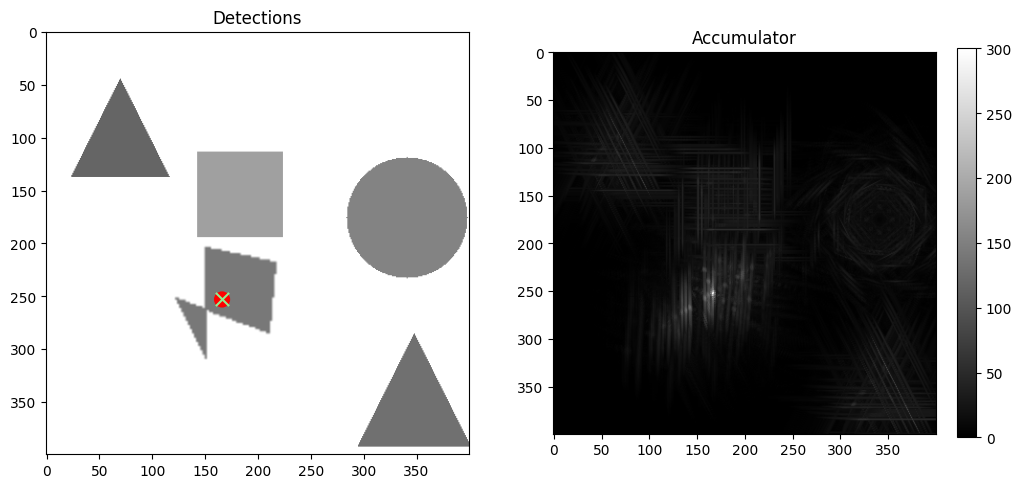

---- Scene Image Number 12 with File Name scene_11.png ----

                     --- Detection Number 1 ---
                            Votes: 206
                            Detected Center (308,142)
                            Scale: 1.5
                            Rotation: 315 deg


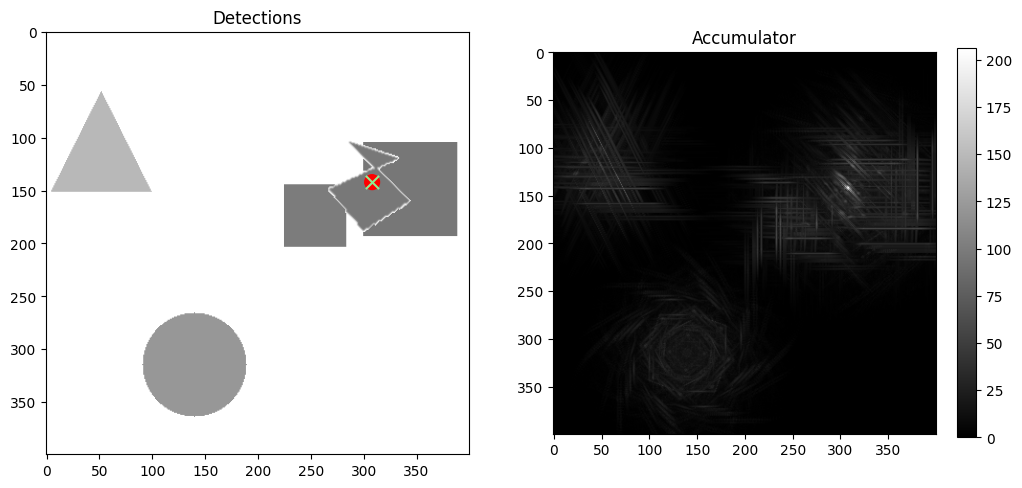

---- Scene Image Number 13 with File Name scene_12.png ----

                     --- Detection Number 1 ---
                            Votes: 157
                            Detected Center (265,191)
                            Scale: 1
                            Rotation: 60 deg


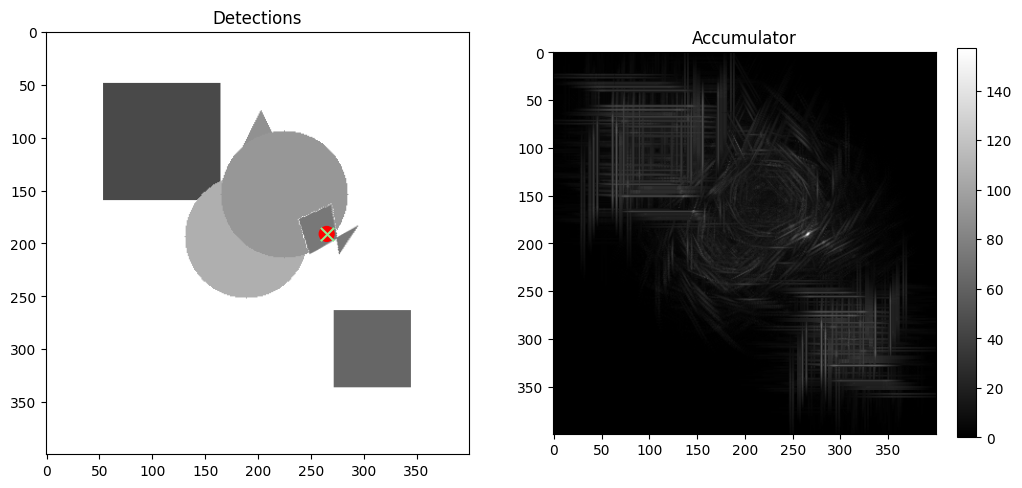

---- Scene Image Number 14 with File Name scene_13.png ----

                     --- Detection Number 1 ---
                            Votes: 164
                            Detected Center (125,329)
                            Scale: 1
                            Rotation: 30 deg


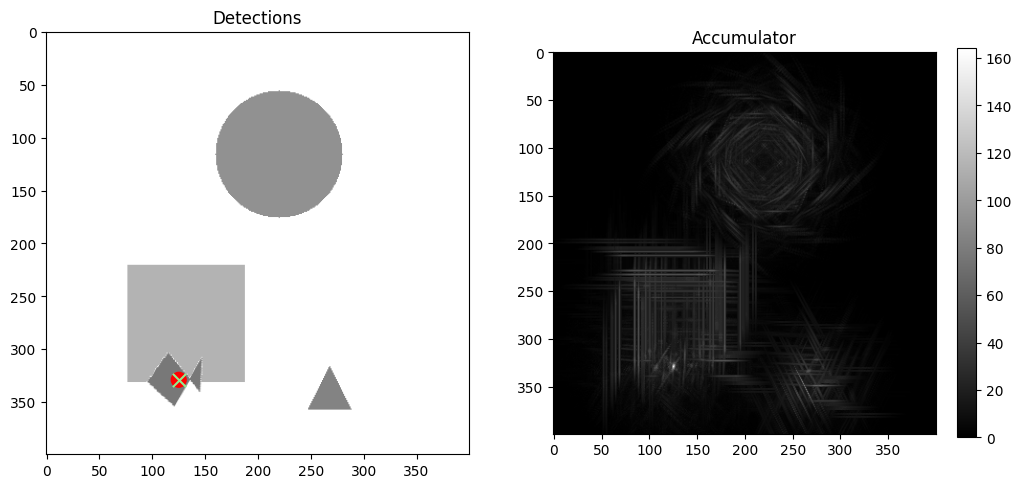

---- Scene Image Number 15 with File Name scene_14.png ----

                     --- Detection Number 1 ---
                            Votes: 267
                            Detected Center (127,256)
                            Scale: 1.5
                            Rotation: 45 deg

                     --- Detection Number 2 ---
                            Votes: 206
                            Detected Center (286,86)
                            Scale: 1.5
                            Rotation: 285 deg


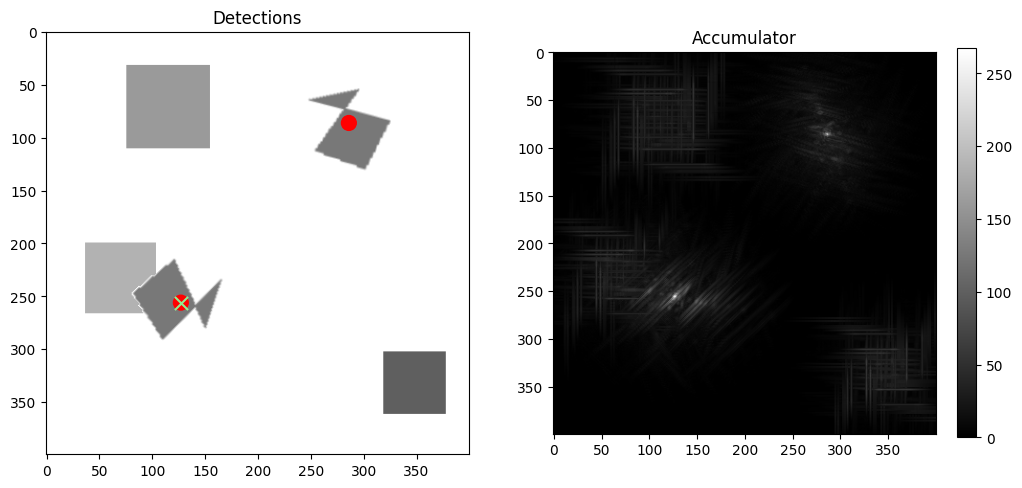

---- Scene Image Number 16 with File Name scene_15.png ----

                     --- Detection Number 1 ---
                            Votes: 253
                            Detected Center (148,253)
                            Scale: 1
                            Rotation: 45 deg

                     --- Detection Number 2 ---
                            Votes: 251
                            Detected Center (215,213)
                            Scale: 2
                            Rotation: 225 deg


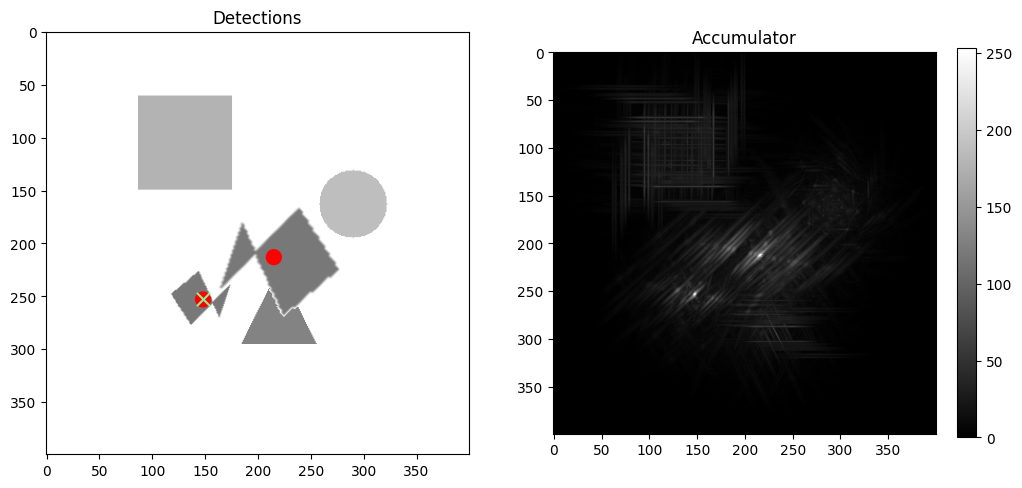

---- Scene Image Number 17 with File Name scene_16.png ----


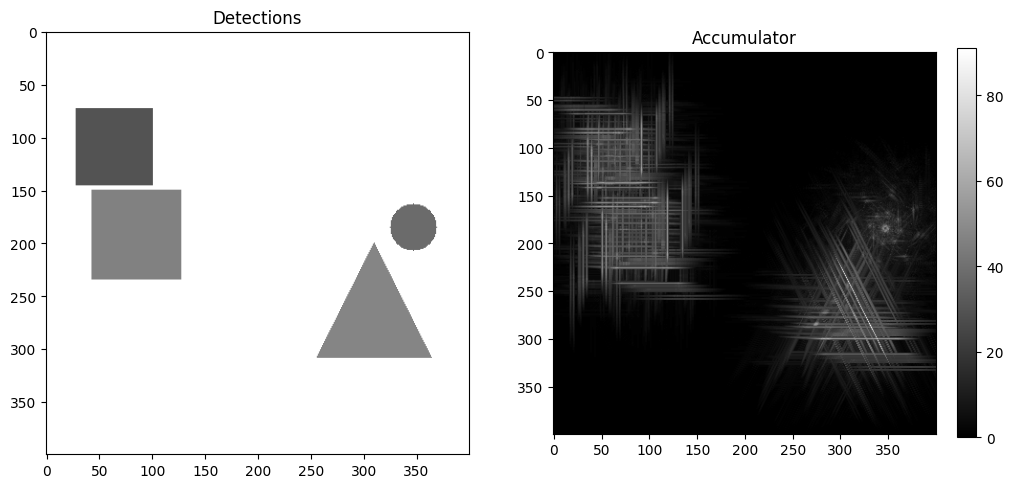

---- Scene Image Number 18 with File Name scene_17.png ----

                     --- Detection Number 1 ---
                            Votes: 227
                            Detected Center (268,163)
                            Scale: 1.5
                            Rotation: 165 deg


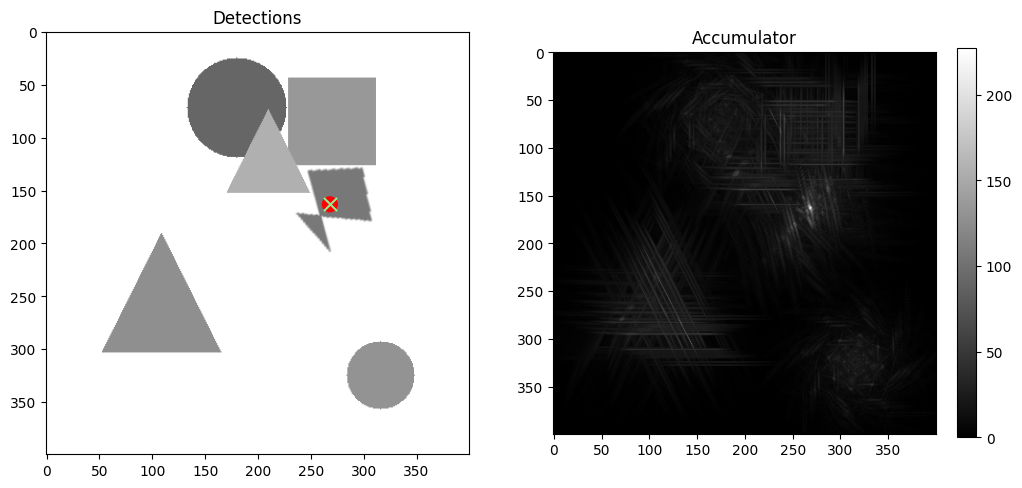

---- Scene Image Number 19 with File Name scene_18.png ----

                     --- Detection Number 1 ---
                            Votes: 225
                            Detected Center (293,86)
                            Scale: 1
                            Rotation: 255 deg

                     --- Detection Number 2 ---
                            Votes: 161
                            Detected Center (150,87)
                            Scale: 1.5
                            Rotation: 270 deg

                     --- Detection Number 3 ---
                            Votes: 152
                            Detected Center (220,257)
                            Scale: 2
                            Rotation: 330 deg


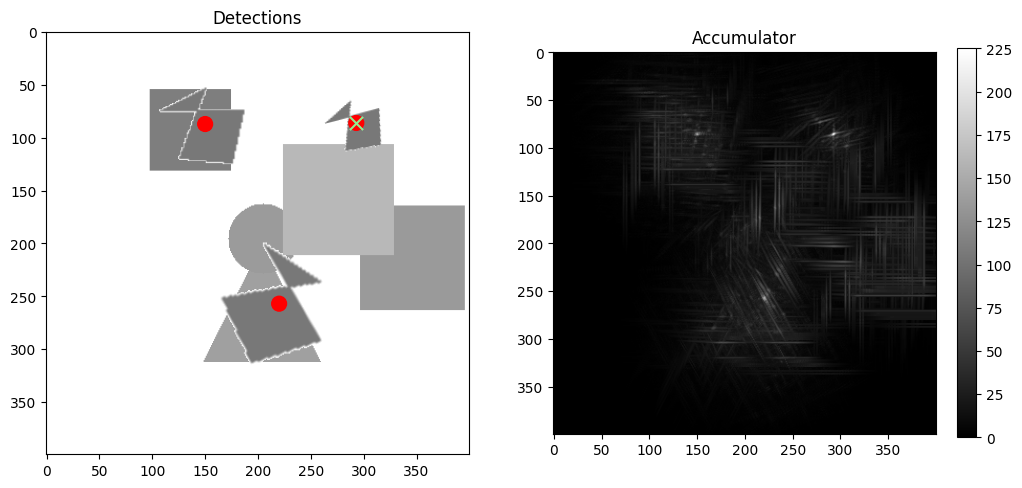

In [15]:
# Visualization
visualize_output(dir_name = fish_dir, images = scenes_fish, parameters = parameters_fish, accumulators = accumulators_fish, colormap = "gray")

- **All of the fish shapes were detected.**
- **The minimum vote count for a fish was 130 (scene_02). This was used to specify the right threshold for accepting vote count values to recognize all of the shapes while discarding noisy data.**
- **The model was able to perform well on the GHT dataset especially after correctly detecting the hardest image of the fish dataset which is scene_02 where it had one fish behind another one. Furthermore, empty images for the fish dataset are actually challenging due to the straight lines characteristic random shapes share with the fish template. However, the model was able to distinguish between these very similar shapes and the fish.**
- **The average time per prediction was approximately 23 seconds.**

### Template Comparison

- **The GHT model performed better and faster with the fish template than the daisy template. The average fish prediction was 19 seconds while the average daisy prediction took about 32 seconds. This can be expected due to the additional complexity the daisy shape exhibits compared to the straight-lined fish template. In fact, thanks to the structure of the given fish template, even line-based GHT is adequate to perform object detection. The same thing does not apply to the curve-based daisy shape. Furthermore, the daisy template had more structures shown in the ray florets surrounding the center. All of these factors explain the performance difference of the model between the two templates. Also, it can be inferred that the fish dataset was easier to predict according to the lower range of vote count compared to the high vote values in the daisy dataset.**
- **The Sobel edge detection was very adequate to accurately draw the boundaries of its shape without much noise. This is also partly due to the clean dataset fed to the GHT model.**
- **Both templates did not have the same vote count threshold. The daisy template maximum vote cannot be less than 100 in order to consider the image non-empty and object detection will stop when the next best detection point has a vote count less than 50% of the maximum vote count. The same maximum vote count for the fish template except that the vote detection will stop when the next best detection point has a vote count less than 55% of the maximum vote count. Both datasets couldn't have the same threshold due to shape complexities. The daisy shape had more vote counts' range than that of th fish shape.**
- **As observed, there were no failure cases in both templates. This was only achieved after adding the binning extension to the r_table to mitigate the high-cardenality issue of the phi angles along with implementing a Non-maximum Suppression(NMS) alike technique in the GHT detect method. This NMS removed extra reference points that detected the same object in a scene. As a result, NMS kept the best reference point with the highest vote count and removed the neighboring points within a radius of 20. The optimal radius was reached through trial and error, meaning maniually checking different values.**

## Summary

- **Building upon the foundation laid by the previous comments and results, the Generalized Hough Transform algorithm created a very capable model in detecting a template in different geometrical properties (different scale and rotation). In fact, this model is adequate to detect random shapes, straight lines, and even circles. However, this model can be more computationally expensive due to the 4D accumulator array and the intermediate steps (offline and during the algorithm) in order to reach the desired results.**
- **Due to higher real world factors aside from scale and rotation along with the existence of higher complex template shapes, GHT original accumulator array can lead into memory errors. One potential solution can include binning the accumulator array itself when it comes to recording the analytical coordinates of the points (x_c, y_c). Afterwards, decoding these bins can be easily implemented to detect the objects with the highest vote count. This is potentially effective as it can disregard the need of the Non-maximum suppression(NMS) technique since neighboring points will be in the same bin and more votes will be given to the right objects. As a result, the gap in vote counts between the right shapes and other random shapes will be infalted leading to easier and more reliable vote count thresholding.**